# Phytogeographic image recognizer

Model to predict scientific name of common botanic species in Rio Blanco - Lima - Peru from a set of photo

Original idea from https://youtu.be/dGtDTjYs3xc

### Import dependencies

In [1]:
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### Test GPU acceleration

In [2]:
from tensorflow import keras
import sys
print(f"GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
print(f"GPUs in use?: {tf.test.is_built_with_cuda()}")
print(f"Tensorflow version: {tf.version.VERSION}")
print(f"System version: {sys.version}")
tf.config.list_physical_devices('GPU')

GPUs Available: 1
GPUs in use?: True
Tensorflow version: 2.10.0
System version: 3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Preparing data of the model

### Constants

In [3]:
Batch_size = 32
Image_size = 288
Channels=3
Epochs=250

### Google Drive (for Google Colab)

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
#%cd '/content/drive/My Drive/Colab Notebooks/Phytogeographic_image_recognizer'

### Import data into tensorflow dataset object

In [6]:
Dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Photos",
    shuffle=True,
    seed=0,
    image_size=(Image_size,Image_size),
    batch_size=Batch_size
)

Found 3619 files belonging to 17 classes.


See the classes found

In [7]:
Class_names = Dataset.class_names
print(len(Class_names))
Class_names

17


['Asteraceae_Baccharis',
 'Asteraceae_mutisia',
 'Bromeliaceae_puya',
 'Buddlejaceae_buddleja',
 'Cactaceae_opuntia',
 'Dennstaedtiaceae_pteridium',
 'Fabaceae_Caesalpinioideae',
 'Liliaceae_bomarea',
 'Myrtaceae_eucalyptus',
 'Passifloraceae_passiflora',
 'Pinaceae_pinus',
 'Poaceae_stipa',
 'Polemoniaceae_monnina',
 'Rosaceae_polylepis',
 'Solanaceae_solanum',
 'Tanacetum',
 'Urticaceae_urtica']

In [8]:
for Image_batch, Labels_batch in Dataset.take(1):
    print(Image_batch.shape)
    print(Labels_batch.numpy())

(32, 288, 288, 3)
[ 8 13  9 12  0  9 14  2 16  3  0  3 16  2  2  1 10  2 12 13  2 16  1  5
 14  0  2  9  5  8  9 16]


Each element in the dataset is a tuple. First element is a batch of 64 elements of images, the second is a batch of 64 elements of class labels.

### Visualize some images of the dataset

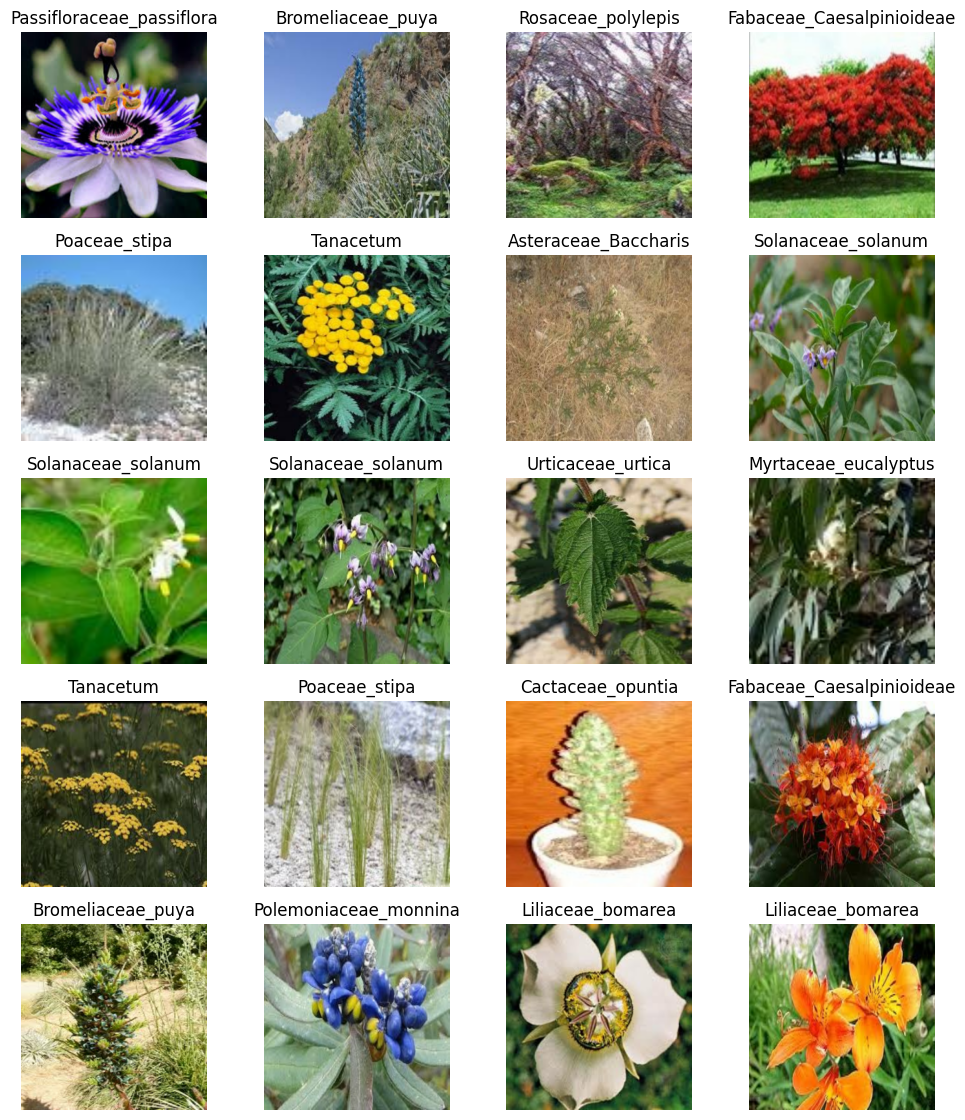

In [9]:
plt.figure(figsize=(12, 14))
for Image_batch, Labels_batch in Dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(Image_batch[i].numpy().astype("uint8"))
        plt.title(Class_names[Labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset will be divided in 3 subsets:
1. Training: Dataset to be used while training (75%)
2. Validation: Dataset to be tested against while training (12.5%)
3. Test: Dataset to be tested against after we trained a model (12.5%)

In [10]:
len(Dataset)

114

### Function to get partitions of the dataset 

In [11]:
def Get_dataset_partitions_tf(Ds, Train_split=0.5, Val_split=0.25, Test_split=0.25, Shuffle=True, Shuffle_size=10000):
    assert (Train_split + Test_split + Val_split) == 1
    
    Ds_size = len(Ds) #Lenght of the Dataset
    
    if Shuffle:
        Ds = Ds.shuffle(Shuffle_size, seed=0) #Suffle
    
    Train_size = int(Train_split * Ds_size) #Size of 0.5 of dataset rounded (or Train_split defined)
    Val_size = int(Val_split * Ds_size) #Size of 0.25 of dataset rounded (or Test_split defined)
    
    Train_ds = Ds.take(Train_size) #Take 0.5 of dataset (or Train_split defined)
    Val_ds = Ds.skip(Train_size).take(Val_size) #Take 0.25 of dataset after 0.6 taked (or Val_split defined)
    Test_ds = Ds.skip(Train_size).skip(Val_size) #Take 0.25 of dataset after 0.8 taked (or Test_split defined)
    
    return Train_ds, Val_ds, Test_ds

In [12]:
Train_ds, Val_ds, Test_ds = Get_dataset_partitions_tf(Dataset)

In [13]:
print(len(Train_ds))
print(len(Val_ds))
print(len(Test_ds))

57
28
29


### Cache, Shuffle, and Prefetch the Dataset

In [14]:
Train_ds = Train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
Val_ds = Val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
Test_ds = Test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the model

### Creating a Layer for Resizing and Normalization

In [15]:
Resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(Image_size, Image_size),
  layers.Rescaling(1./255) #Normalize, 
])

### Data Augmentation
Data Augmentation is needed for augmenting the data. Boosts the accuracy of our model by augmenting the data.

In [16]:
Data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.005),
  layers.RandomContrast(0.005),
  layers.RandomZoom(height_factor=0.005,width_factor=0.005)
])

#### Applying Data Augmentation to Train Dataset

In [17]:
Train_ds = Train_ds.map(
    lambda x, y: (Data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture
I will use a CNN coupled with a Softmax activation in the output layer. CNN is popular for image classification. I also add the initial layers for resizing, normalization and Data Augmentation.

In [18]:
Input_shape = (Batch_size, Image_size, Image_size, Channels)
N_classes = len(Class_names) #Number of classes

Model = models.Sequential([
    Resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=Input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.75), 
    layers.Dense(64, activation='relu'),
    layers.Dense(N_classes, activation='softmax'),
])

Model.build(input_shape=Input_shape)

In [19]:
Model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 288, 288, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 286, 286, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 143, 143, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 141, 141, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 70, 70, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 68, 68, 64)         

### Compiling the Model

In [20]:
Model.compile(
    optimizer = 'adam',
    loss = "SparseCategoricalCrossentropy",
    metrics = ['accuracy']
)

Make a checkpoint to use the better run by accuracy

In [21]:
Checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'Checkpoint_model.hdf5',
    verbose = 1,
    monitor = 'accuracy',
    save_best_only = True
)

In [22]:
History = Model.fit(
    Train_ds,
    batch_size=Batch_size,
    validation_data=Val_ds,
    callbacks=[Checkpoint],
    verbose=1,
    epochs=Epochs,
)

Epoch 1/250
57/57 [==============================] - ETA: 0s - loss: 2.8293 - accuracy: 0.0587
Epoch 1: accuracy improved from -inf to 0.05866, saving model to Checkpoint_model.hdf5
57/57 [==============================] - 24s 199ms/step - loss: 2.8293 - accuracy: 0.0587 - val_loss: 2.8229 - val_accuracy: 0.0614
Epoch 2/250
57/57 [==============================] - ETA: 0s - loss: 2.8049 - accuracy: 0.0636
Epoch 2: accuracy improved from 0.05866 to 0.06360, saving model to Checkpoint_model.hdf5
57/57 [==============================] - 10s 171ms/step - loss: 2.8049 - accuracy: 0.0636 - val_loss: 2.7501 - val_accuracy: 0.0792
Epoch 3/250
57/57 [==============================] - ETA: 0s - loss: 2.7551 - accuracy: 0.0992
Epoch 3: accuracy improved from 0.06360 to 0.09923, saving model to Checkpoint_model.hdf5
57/57 [==============================] - 10s 169ms/step - loss: 2.7551 - accuracy: 0.0992 - val_loss: 2.7063 - val_accuracy: 0.0960
Epoch 4/250
57/57 [==============================] -

57/57 [==============================] - 10s 168ms/step - loss: 2.0508 - accuracy: 0.3251 - val_loss: 2.0212 - val_accuracy: 0.3348
Epoch 28/250
57/57 [==============================] - ETA: 0s - loss: 2.0217 - accuracy: 0.3355
Epoch 28: accuracy improved from 0.32511 to 0.33553, saving model to Checkpoint_model.hdf5
57/57 [==============================] - 10s 177ms/step - loss: 2.0217 - accuracy: 0.3355 - val_loss: 1.9899 - val_accuracy: 0.3549
Epoch 29/250
57/57 [==============================] - ETA: 0s - loss: 1.9773 - accuracy: 0.3459
Epoch 29: accuracy improved from 0.33553 to 0.34594, saving model to Checkpoint_model.hdf5
57/57 [==============================] - 10s 169ms/step - loss: 1.9773 - accuracy: 0.3459 - val_loss: 1.9330 - val_accuracy: 0.3638
Epoch 30/250
57/57 [==============================] - ETA: 0s - loss: 2.0075 - accuracy: 0.3328
Epoch 30: accuracy did not improve from 0.34594
57/57 [==============================] - 10s 170ms/step - loss: 2.0075 - accuracy: 0.3

Epoch 55/250
57/57 [==============================] - ETA: 0s - loss: 1.3625 - accuracy: 0.5444
Epoch 55: accuracy improved from 0.51371 to 0.54441, saving model to Checkpoint_model.hdf5
57/57 [==============================] - 10s 170ms/step - loss: 1.3625 - accuracy: 0.5444 - val_loss: 1.5451 - val_accuracy: 0.5391
Epoch 56/250
57/57 [==============================] - ETA: 0s - loss: 1.3333 - accuracy: 0.5493
Epoch 56: accuracy improved from 0.54441 to 0.54934, saving model to Checkpoint_model.hdf5
57/57 [==============================] - 10s 172ms/step - loss: 1.3333 - accuracy: 0.5493 - val_loss: 1.5591 - val_accuracy: 0.5513
Epoch 57/250
57/57 [==============================] - ETA: 0s - loss: 1.3510 - accuracy: 0.5466
Epoch 57: accuracy did not improve from 0.54934
57/57 [==============================] - 10s 172ms/step - loss: 1.3510 - accuracy: 0.5466 - val_loss: 1.7838 - val_accuracy: 0.5000
Epoch 58/250
57/57 [==============================] - ETA: 0s - loss: 1.3287 - accurac

57/57 [==============================] - ETA: 0s - loss: 0.8830 - accuracy: 0.7133
Epoch 82: accuracy improved from 0.69024 to 0.71327, saving model to Checkpoint_model.hdf5
57/57 [==============================] - 10s 168ms/step - loss: 0.8830 - accuracy: 0.7133 - val_loss: 1.6161 - val_accuracy: 0.6373
Epoch 83/250
57/57 [==============================] - ETA: 0s - loss: 0.8741 - accuracy: 0.6990
Epoch 83: accuracy did not improve from 0.71327
57/57 [==============================] - 10s 168ms/step - loss: 0.8741 - accuracy: 0.6990 - val_loss: 1.5772 - val_accuracy: 0.6406
Epoch 84/250
57/57 [==============================] - ETA: 0s - loss: 0.8642 - accuracy: 0.7039
Epoch 84: accuracy did not improve from 0.71327
57/57 [==============================] - 10s 169ms/step - loss: 0.8642 - accuracy: 0.7039 - val_loss: 1.6687 - val_accuracy: 0.6283
Epoch 85/250
57/57 [==============================] - ETA: 0s - loss: 0.8790 - accuracy: 0.7105
Epoch 85: accuracy did not improve from 0.7132

57/57 [==============================] - 9s 166ms/step - loss: 0.6024 - accuracy: 0.7950 - val_loss: 1.7114 - val_accuracy: 0.6752
Epoch 110/250
57/57 [==============================] - ETA: 0s - loss: 0.5696 - accuracy: 0.8037
Epoch 110: accuracy improved from 0.79496 to 0.80373, saving model to Checkpoint_model.hdf5
57/57 [==============================] - 10s 168ms/step - loss: 0.5696 - accuracy: 0.8037 - val_loss: 1.8359 - val_accuracy: 0.6663
Epoch 111/250
57/57 [==============================] - ETA: 0s - loss: 0.6023 - accuracy: 0.7895
Epoch 111: accuracy did not improve from 0.80373
57/57 [==============================] - 10s 167ms/step - loss: 0.6023 - accuracy: 0.7895 - val_loss: 1.6856 - val_accuracy: 0.6842
Epoch 112/250
57/57 [==============================] - ETA: 0s - loss: 0.5912 - accuracy: 0.7966
Epoch 112: accuracy did not improve from 0.80373
57/57 [==============================] - 9s 166ms/step - loss: 0.5912 - accuracy: 0.7966 - val_loss: 1.7983 - val_accuracy: 

Epoch 138/250
57/57 [==============================] - ETA: 0s - loss: 0.4468 - accuracy: 0.8558
Epoch 138: accuracy did not improve from 0.86294
57/57 [==============================] - 10s 168ms/step - loss: 0.4468 - accuracy: 0.8558 - val_loss: 1.8592 - val_accuracy: 0.6920
Epoch 139/250
57/57 [==============================] - ETA: 0s - loss: 0.4612 - accuracy: 0.8470
Epoch 139: accuracy did not improve from 0.86294
57/57 [==============================] - 9s 166ms/step - loss: 0.4612 - accuracy: 0.8470 - val_loss: 1.9096 - val_accuracy: 0.6864
Epoch 140/250
57/57 [==============================] - ETA: 0s - loss: 0.4512 - accuracy: 0.8536
Epoch 140: accuracy did not improve from 0.86294
57/57 [==============================] - 9s 167ms/step - loss: 0.4512 - accuracy: 0.8536 - val_loss: 1.9930 - val_accuracy: 0.6864
Epoch 141/250
57/57 [==============================] - ETA: 0s - loss: 0.5171 - accuracy: 0.8289
Epoch 141: accuracy did not improve from 0.86294
57/57 [===============

57/57 [==============================] - ETA: 0s - loss: 0.4161 - accuracy: 0.8734
Epoch 167: accuracy did not improve from 0.88213
57/57 [==============================] - 9s 165ms/step - loss: 0.4161 - accuracy: 0.8734 - val_loss: 2.0341 - val_accuracy: 0.6797
Epoch 168/250
57/57 [==============================] - ETA: 0s - loss: 0.3471 - accuracy: 0.8838
Epoch 168: accuracy improved from 0.88213 to 0.88377, saving model to Checkpoint_model.hdf5
57/57 [==============================] - 9s 166ms/step - loss: 0.3471 - accuracy: 0.8838 - val_loss: 2.0211 - val_accuracy: 0.6953
Epoch 169/250
57/57 [==============================] - ETA: 0s - loss: 0.3998 - accuracy: 0.8668
Epoch 169: accuracy did not improve from 0.88377
57/57 [==============================] - 10s 167ms/step - loss: 0.3998 - accuracy: 0.8668 - val_loss: 2.1463 - val_accuracy: 0.6931
Epoch 170/250
57/57 [==============================] - ETA: 0s - loss: 0.3705 - accuracy: 0.8865
Epoch 170: accuracy improved from 0.88377 

Epoch 196/250
57/57 [==============================] - ETA: 0s - loss: 0.3032 - accuracy: 0.9035
Epoch 196: accuracy improved from 0.90022 to 0.90351, saving model to Checkpoint_model.hdf5
57/57 [==============================] - 10s 167ms/step - loss: 0.3032 - accuracy: 0.9035 - val_loss: 2.1653 - val_accuracy: 0.7042
Epoch 197/250
57/57 [==============================] - ETA: 0s - loss: 0.2955 - accuracy: 0.9052
Epoch 197: accuracy improved from 0.90351 to 0.90515, saving model to Checkpoint_model.hdf5
57/57 [==============================] - 10s 168ms/step - loss: 0.2955 - accuracy: 0.9052 - val_loss: 2.3785 - val_accuracy: 0.6842
Epoch 198/250
57/57 [==============================] - ETA: 0s - loss: 0.2950 - accuracy: 0.9046
Epoch 198: accuracy did not improve from 0.90515
57/57 [==============================] - 9s 166ms/step - loss: 0.2950 - accuracy: 0.9046 - val_loss: 2.3626 - val_accuracy: 0.6931
Epoch 199/250
57/57 [==============================] - ETA: 0s - loss: 0.3402 - a

Epoch 225/250
57/57 [==============================] - ETA: 0s - loss: 0.2788 - accuracy: 0.9084
Epoch 225: accuracy did not improve from 0.91447
57/57 [==============================] - 10s 167ms/step - loss: 0.2788 - accuracy: 0.9084 - val_loss: 2.2459 - val_accuracy: 0.6842
Epoch 226/250
57/57 [==============================] - ETA: 0s - loss: 0.2962 - accuracy: 0.9046
Epoch 226: accuracy did not improve from 0.91447
57/57 [==============================] - 10s 167ms/step - loss: 0.2962 - accuracy: 0.9046 - val_loss: 2.3958 - val_accuracy: 0.6964
Epoch 227/250
57/57 [==============================] - ETA: 0s - loss: 0.3178 - accuracy: 0.9019
Epoch 227: accuracy did not improve from 0.91447
57/57 [==============================] - 9s 166ms/step - loss: 0.3178 - accuracy: 0.9019 - val_loss: 2.2453 - val_accuracy: 0.6987
Epoch 228/250
57/57 [==============================] - ETA: 0s - loss: 0.3483 - accuracy: 0.8925
Epoch 228: accuracy did not improve from 0.91447
57/57 [==============

**Load the best model (better accuracy)**

In [23]:
Model_checkpoint_best = Model
Model_checkpoint_best.load_weights('./Checkpoint_model.hdf5')

In [24]:
Scores = Model_checkpoint_best.evaluate(Test_ds)

29/29 [==============================] - 3s 20ms/step - loss: 2.4160 - accuracy: 0.7241


Scores is a list containing loss and accuracy value respectively
xxxxxxxxxxx% is a decent accuracy

In [25]:
Scores

[2.4160289764404297, 0.7241379022598267]

### Plotting the Accuracy and Loss Curves

In [26]:
History

In [27]:
History.params

{'verbose': 1, 'epochs': 250, 'steps': 57}

In [28]:
History.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**'loss', 'accuracy', 'val loss' and 'val_accuracy' are a python list containing values at the end of each epoch**

In [29]:
type(History.history['loss'])

list

In [30]:
len(History.history['loss'])

250

In [31]:
History.history['loss'][:5] #Loss for first 5 epochs

[2.8292899131774902,
 2.8048994541168213,
 2.755072832107544,
 2.6800925731658936,
 2.6429600715637207]

In [32]:
Acc = History.history['accuracy']
Val_acc = History.history['val_accuracy']

Loss = History.history['loss']
Val_loss = History.history['val_loss']

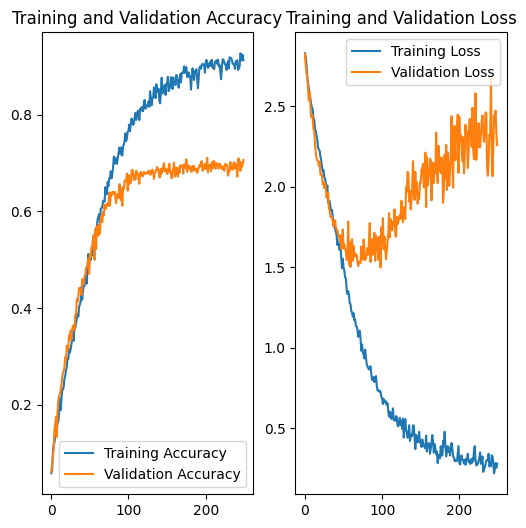

In [33]:
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(range(Epochs), Acc, label='Training Accuracy')
plt.plot(range(Epochs), Val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(Epochs), Loss, label='Training Loss')
plt.plot(range(Epochs), Val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

First image to predict
Actual label: Cactaceae_opuntia
1/1 [==============================] - 0s 110ms/step
predicted label: Cactaceae_opuntia


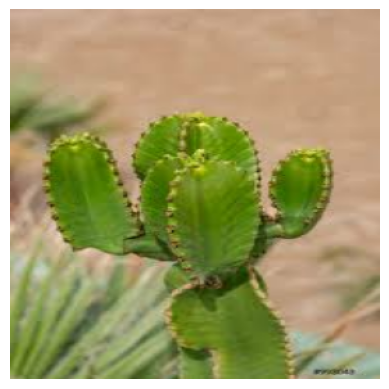

In [34]:
for Images_batch, Labels_batch in Test_ds.take(1):
    First_image = Images_batch[0].numpy().astype('uint8')
    First_label = Labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(First_image)
    plt.axis("off")
    print("Actual label:",Class_names[First_label])
    
    Batch_prediction = Model_checkpoint_best.predict(Images_batch)
    print("predicted label:",Class_names[np.argmax(Batch_prediction[0])])

### Write a function for inference

In [35]:
def Predict(Model, Img):
    Img_array = tf.keras.preprocessing.image.img_to_array(Images[i].numpy())
    Img_array = tf.expand_dims(Img_array, 0)

    Predictions = Model.predict(Img_array)

    Predicted_class = Class_names[np.argmax(Predictions[0])]
    Confidence = round(100 * (np.max(Predictions[0])), 2)
    return Predicted_class, Confidence

1/1 [==============================] - 0s 16ms/step


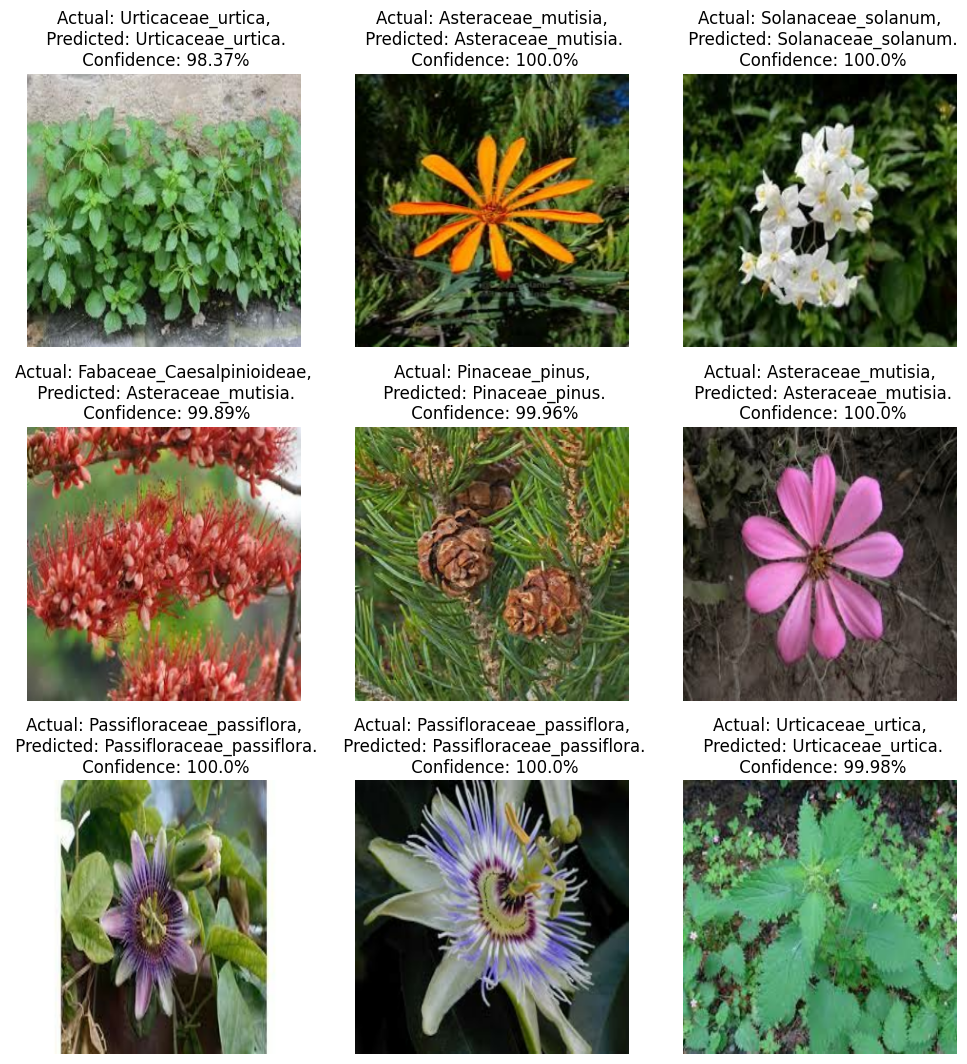

In [39]:
plt.figure(figsize=(12, 13))
for Images, Labels in Test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(Images[i].numpy().astype("uint8"))
        
        Predicted_class, Confidence = Predict(Model_checkpoint_best, Images[i].numpy())
        Actual_class = Class_names[Labels[i]]
        
        plt.title(f"Actual: {Actual_class},\n Predicted: {Predicted_class}.\n Confidence: {Confidence}%")
        plt.axis("off")

### Saving the Model

In [40]:
import os

Dir = "./Saved_models"
if os.path.exists(Dir):
    Model_version=max([int(i) for i in os.listdir(Dir) + [0]])+1
    Model_checkpoint_best.save(f"./Saved_models/{Model_version}")
else:
    os.mkdir(Dir)
    Model_version=max([int(i) for i in os.listdir(Dir) + [0]])+1
    Model_checkpoint_best.save(f"./Saved_models/{Model_version}")

INFO:tensorflow:Assets written to: ./Saved_models/1\assets


INFO:tensorflow:Assets written to: ./Saved_models/1\assets
